In [1]:
import os
data_dir = 'D:/AI PIAIC/Deep Learning data/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [5]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

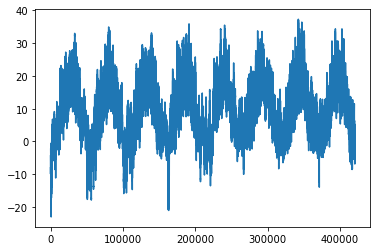

In [6]:
from matplotlib import pyplot as plt
temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

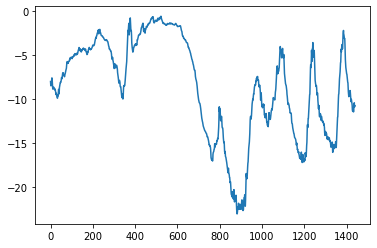

In [7]:
plt.plot(range(1440), temp[:1440])

In [8]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [9]:
float_data.shape

(420451, 14)

In [10]:
float_data.shape[-1]

14

In [11]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [12]:
lookback = 720
step = 3
delay = 144

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step)

val_steps = (300000 - 200001 - lookback) // 128

test_steps = (len(float_data) - 300001 - lookback) // 128



In [8]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

evaluate_naive_method()

0.2830632928683155


In [9]:
celsius_mae = 0.29 * std[1]

In [10]:
celsius_mae

2.5672247338393395

In [13]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

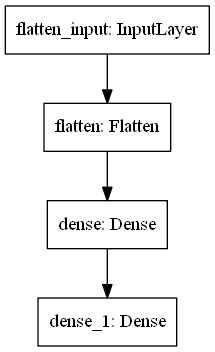

In [14]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [12]:
model.compile(optimizer=RMSprop(), loss='mae')

In [15]:
history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2991 - val_loss: 0.2849
Epoch 2/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2792 - val_loss: 0.2843
Epoch 3/20
500/500 [==============================] - 15s 29ms/step - loss: 0.2683 - val_loss: 0.2900
Epoch 4/20
500/500 [==============================] - 14s 29ms/step - loss: 0.2624 - val_loss: 0.2915
Epoch 5/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2558 - val_loss: 0.2853
Epoch 6/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2544 - val_loss: 0.3255
Epoch 7/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2501 - val_loss: 0.3008
Epoch 8/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2500 - val_loss: 0.2977
Epoch 9/20
500/500 [==============================] - 14s 29ms/step - loss: 0.2453 - val_loss: 0.2896
Epoch 10/20
500/500 [==============================] - 14s 28ms/step - loss: 0.243

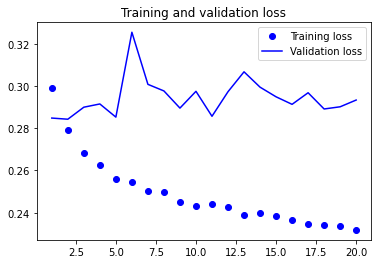

In [16]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [2]:
import numpy

In [3]:
numpy.version.version

'1.18.5'

In [34]:
import tensorflow
tensorflow.__version__

'2.3.0'

In [38]:
from platform import python_version

In [41]:
python_version()

'3.8.11'

In [15]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')

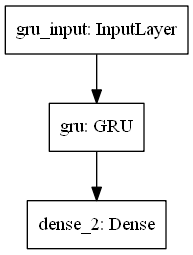

In [16]:
plot_model(model, to_file='model.png')

In [13]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 85s 170ms/step - loss: 0.2974 - val_loss: 0.2768
Epoch 2/20
500/500 [==============================] - 92s 184ms/step - loss: 0.2831 - val_loss: 0.2621
Epoch 3/20
500/500 [==============================] - 89s 178ms/step - loss: 0.2791 - val_loss: 0.2629
Epoch 4/20
500/500 [==============================] - 85s 169ms/step - loss: 0.2745 - val_loss: 0.2575
Epoch 5/20
500/500 [==============================] - 82s 165ms/step - loss: 0.2706 - val_loss: 0.2620
Epoch 6/20
500/500 [==============================] - 81s 162ms/step - loss: 0.2645 - val_loss: 0.2673
Epoch 7/20
500/500 [==============================] - 81s 162ms/step - loss: 0.2627 - val_loss: 0.2636
Epoch 8/20
500/500 [==============================] - 81s 162ms/step - loss: 0.2575 - val_loss: 0.2616
Epoch 9/20
500/500 [==============================] - 82s 164ms/step - loss: 0.2543 - val_loss: 0.2689
Epoch 10/20
500/500 [==============================] - 81s 162ms/step - l

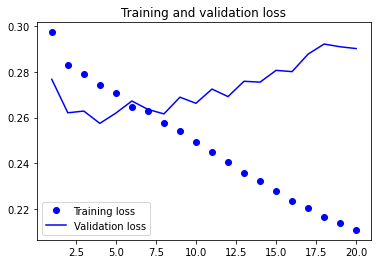

In [14]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [20]:
scores = model.evaluate(test_gen, steps=test_steps) #1514 testing images

935/935 [==============================] - 35s 37ms/step - loss: 0.3079


TypeError: 'float' object is not subscriptable

In [21]:
scores

0.3079110383987427

In [22]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
_________________________________________________________________


In [17]:
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
_________________________________________________________________


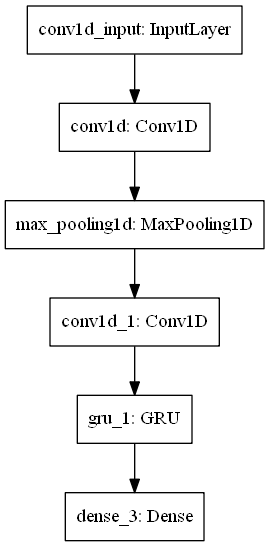

In [18]:
plot_model(model, to_file='model.png')

In [23]:
model.compile(optimizer=RMSprop(), loss='mae')

In [25]:
history = model.fit(train_gen,
                    steps_per_epoch=100,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/20
100/100 [==============================] - 28s 285ms/step - loss: 0.3511 - val_loss: 0.2976
Epoch 2/20
100/100 [==============================] - 27s 270ms/step - loss: 0.3280 - val_loss: 0.2996
Epoch 3/20
100/100 [==============================] - 29s 294ms/step - loss: 0.3179 - val_loss: 0.2895
Epoch 4/20
100/100 [==============================] - 27s 274ms/step - loss: 0.3077 - val_loss: 0.2945
Epoch 5/20
100/100 [==============================] - 27s 270ms/step - loss: 0.3068 - val_loss: 0.2766
Epoch 6/20
100/100 [==============================] - 27s 270ms/step - loss: 0.3001 - val_loss: 0.2825
Epoch 7/20
100/100 [==============================] - 27s 272ms/step - loss: 0.3018 - val_loss: 0.2805
Epoch 8/20
100/100 [==============================] - 27s 270ms/step - loss: 0.2991 - val_loss: 0.2788
Epoch 9/20
100/100 [==============================] - 27s 270ms/step - loss: 0.2905 - val_loss: 0.2782
Epoch 10/20
100/100 [==============================] - 27s 272ms/step - l

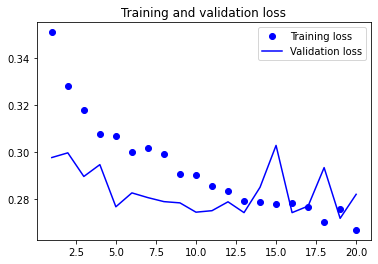

In [26]:

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [27]:
scores = model.evaluate(test_gen, steps=test_steps)

935/935 [==============================] - 22s 24ms/step - loss: 0.2959


In [28]:
scores

0.2959112226963043

In [ ]:
 v